In [1]:
import numpy as np
import pickle
import json
import os
import yaml

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

from utils.datasets import get_generators, create_classifier_dataset
from utils.misc import log_config
from utils.train.visualization import analyze_history
from utils.train.classifier import load_model
from config.datasets_config import DATASETS_CONFIG

In [2]:
def configure_saving():
    # Generate save directory and store in config
    save_dir = os.path.join(config['root_save_dir'], config['model_name'])
    config['save_dir'] = save_dir

    # Create save directory (if it does not exist)
    try:
        os.makedirs(save_dir, exist_ok=False)
    except FileExistsError:
        input_ = input('save_dir already exists, continue? (Y/n)  >> ')
        if input_ != 'Y':
            raise ValueError

In [3]:
def load_datasets():
    dataset_config['train_split'] = config['train_split']
    dataset_config['validation_split'] = config['validation_split']

    # Load data generators
    datagen, datagen_val, datagen_test = get_generators(
        ['train', 'val', 'test'],
        config['image_shape'],
        batch_size=1,  # batched later
        random_seed=config['random_seed'],
        dataset_config=dataset_config
    )
    classes = list(datagen.class_indices.keys())
    config['classes'] = classes
    config['num_classes'] = len(classes)

    # Load class weight
    class_weight = None
    if config['use_class_weight']:
        with open(os.path.join(dataset_config['dataset_dir'], 'class_weight.json'), 'r') as f:
            class_weight = json.load(f)
        groups = dataset_config['groups']
        class_weight = {groups[k]: v for k, v in class_weight.items() if k in groups.keys()}
        class_weight = {datagen.class_indices[k]: v for k, v in class_weight.items()}
        print('Using class weights:', class_weight)
    config['class_weight'] = class_weight

    # Load datasets
    datasets, steps = [], []
    for gen in [datagen, datagen_val, datagen_test]:
        ds = create_classifier_dataset(gen, config['image_shape'], len(classes))
        ds = ds.batch(config['batch_size'])
        ds = ds.prefetch(config['prefetch'])

        steps.append(len(gen) // config['batch_size'])
        datasets.append(ds)
    config['steps'] = steps

    return datasets

In [28]:
with open('config/classifier_config.yaml') as file:
    config = yaml.safe_load(file)

dataset_config = DATASETS_CONFIG[config['dataset_type']]

np.random.seed(config['random_seed'])
tf.random.set_seed(config['random_seed'])

# Supervised VAE vaseline training setup
# config['model_type'] = 'vae'
# config['model_name'] = 'supervised_vae_adam_plateau'
# config['encoder_weights_path'] = None

# Supervised baseline training setup
# config['model_type'] = 'resnet50'
# config['model_name'] = 'supervised_baseline'
# config['encoder_weights_path'] = None
# config['head_lr'] = 0.01
# config['encoder_lr'] = 0.01

# Barlow Twins baseline training setup
config['model_type'] = 'resnet50'
config['model_name'] = 'lamb_100_4096_0.025'
config['encoder_weights_path'] = 'trained_models/encoders/lamb_100_4096/resnet.h5'
config['head_lr'] = 0.025
config['encoder_lr'] = 0.025

In [29]:
config['encoder_trainable'] = True
config['lr_scheduler'] = 'cosine'
config['optimizer'] = 'sgdw'

if config['model_type'] == 'vae':
    config['latent_dim'] = 512
    config['head_lr'] = 1e-3
    config['encoder_lr'] = 1e-3

In [30]:
configure_saving()

# Load dataset and model
datasets = load_datasets()
model = load_model(config_dict=config)

# Create training callbacks
callbacks = []
if config['patience'] is not None:
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=config['patience'])
    callbacks.append(es)
else:
    del config['patience']
    
if config['lr_scheduler'] == 'plateau':
    reduce = ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=3,
        verbose=1
    )
    callbacks.append(reduce)

mc = ModelCheckpoint(
    os.path.join(config['save_dir'], 'classifier.h5'),
    monitor='val_auc', 
    mode='max',
    verbose=1,
    save_best_only=True, save_weights_only=True
)
callbacks.append(mc)

# Print and save the configuration
log_config(config, save_config=True)

Found 11838 validated image filenames belonging to 6 classes.
Found 17759 validated image filenames belonging to 6 classes.
Found 20661 validated image filenames belonging to 6 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 23,531,654
Non-trai

In [31]:
# Train the model
history = model.fit(
    datasets[0],
    epochs=config['epochs'],
    steps_per_epoch=config['steps'][0],
    validation_steps=config['steps'][1],
    validation_data=datasets[1],
    callbacks=callbacks,
    class_weight=config['class_weight']
)

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 1.1838 - acc: 0.5421 - top_2_accuracy: 0.7283 - MCC: 0.3484 - auc: 0.7689
Epoch 00001: val_auc improved from -inf to 0.55945, saving model to trained_models/classifiers/lamb_100_4096_0.025/classifier.h5
46/46 [==============================] - 100s 2s/step - loss: 1.1838 - acc: 0.5421 - top_2_accuracy: 0.7283 - MCC: 0.3484 - auc: 0.7689 - val_loss: 2.1743 - val_acc: 0.0924 - val_top_2_accuracy: 0.2820 - val_MCC: 0.0277 - val_auc: 0.5595
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.7069 - acc: 0.7344 - top_2_accuracy: 0.9086 - MCC: 0.6013 - auc: 0.9099
Epoch 00002: val_auc did not improve from 0.55945
46/46 [==============================] - 84s 2s/step - loss: 0.7069 - acc: 0.7344 - top_2_accuracy: 0.9086 - MCC: 0.6013 - auc: 0.9099 - val_loss: 9.7084 - val_acc: 0.0528 - val_top_2_accuracy: 0.3819 - val_MCC: -0.0230 - val_auc: 0.5211
Epoch 3/30
46/46 [==============================] - ETA: 0s -

46/46 [==============================] - 84s 2s/step - loss: 0.0499 - acc: 0.9844 - top_2_accuracy: 0.9990 - MCC: 0.9771 - auc: 0.9995 - val_loss: 0.8065 - val_acc: 0.7866 - val_top_2_accuracy: 0.9339 - val_MCC: 0.6943 - val_auc: 0.9401
Epoch 19/30
46/46 [==============================] - ETA: 0s - loss: 0.0276 - acc: 0.9928 - top_2_accuracy: 0.9997 - MCC: 0.9894 - auc: 0.9999
Epoch 00019: val_auc did not improve from 0.94009
46/46 [==============================] - 83s 2s/step - loss: 0.0276 - acc: 0.9928 - top_2_accuracy: 0.9997 - MCC: 0.9894 - auc: 0.9999 - val_loss: 1.0580 - val_acc: 0.7420 - val_top_2_accuracy: 0.9124 - val_MCC: 0.6241 - val_auc: 0.9035
Epoch 20/30
46/46 [==============================] - ETA: 0s - loss: 0.0183 - acc: 0.9958 - top_2_accuracy: 0.9998 - MCC: 0.9939 - auc: 0.9999
Epoch 00020: val_auc did not improve from 0.94009
46/46 [==============================] - 83s 2s/step - loss: 0.0183 - acc: 0.9958 - top_2_accuracy: 0.9998 - MCC: 0.9939 - auc: 0.9999 - val

In [33]:
# Save the training history
with open(os.path.join(config['save_dir'], 'history.pickle'), 'wb') as f:
    pickle.dump(history.history, f)

# Load best model, save encoder weights (separately), and evaluate model
model.load_weights(os.path.join(config['save_dir'], 'classifier.h5'))
model.layers[1].save_weights(os.path.join(config['save_dir'], 'encoder.h5'))
model.evaluate(datasets[2], steps=config['steps'][2])

80/80 [==============================] - 59s 737ms/step - loss: 0.9625 - acc: 0.7842 - top_2_accuracy: 0.9208 - MCC: 0.6733 - auc: 0.9013


[0.962475597858429,
 0.784228503704071,
 0.9208008050918579,
 0.6733418703079224,
 0.9013066291809082]

['fat', 'necrotic_debris', 'plasma_cell_infiltrate', 'stroma', 'tils', 'tumor']

In [123]:
for lr in [1]:
    print('Evaluating:', lr)
    
    model.load_weights(f'trained_models/classifiers/supervised_lr_{lr}/classifier.h5')
    model.evaluate(datasets[2], steps=config['steps'][2])

Evaluating: 0.005
80/80 [==============================] - 59s 743ms/step - loss: 0.6016 - acc: 0.8063 - top_2_accuracy: 0.9398 - MCC: 0.7063 - auc: 0.8239
Evaluating: 0.02
80/80 [==============================] - 60s 753ms/step - loss: 0.7038 - acc: 0.7423 - top_2_accuracy: 0.9238 - MCC: 0.6168 - auc: 0.8019


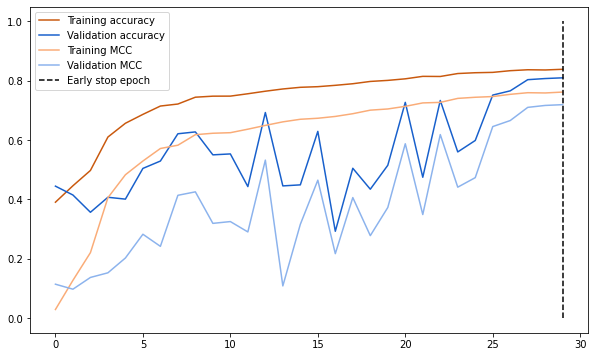

In [109]:
analyze_history(
    history_path=os.path.join(config['save_dir'], 'history.pickle'),
    return_es_stats=False,
    root_save_dir=config['save_dir']
)

In [ ]:
config['optimizer'] = 'adam'
config['lr_scheduler'] = 'plateau'

for lr in [0.005, 0.02]:
    with open('config/classifier_config.yaml') as file:
        config = yaml.safe_load(file)

    dataset_config = DATASETS_CONFIG[config['dataset_type']]

    np.random.seed(config['random_seed'])
    tf.random.set_seed(config['random_seed'])

    # Barlow Twins baseline training setup
    config['model_type'] = 'resnet50'
    config['encoder_weights_path'] = None  #'trained_models/encoders/encoder_resnet50_100_baseline/resnet.h5'
    
    config['encoder_trainable'] = True
    config['lr_scheduler'] = 'plateau'
    config['optimizer'] = 'adam'
    
    config['model_name'] = f'supervised_lr_{lr}'
    config['head_lr'] = lr
    config['encoder_lr'] = lr
    
    configure_saving()

    # Load dataset and model
    datasets = load_datasets()
    model = load_model(config_dict=config)

    # Create training callbacks
    callbacks = []
    if config['patience'] is not None:
        es = EarlyStopping(monitor='val_mcc', mode='max', verbose=1, patience=config['patience'])
        callbacks.append(es)
    else:
        del config['patience']

    if config['lr_scheduler'] == 'plateau':
        reduce = ReduceLROnPlateau(
            monitor='val_acc',
            factor=0.2,
            patience=3,
            verbose=1
        )
        callbacks.append(reduce)

    mc = ModelCheckpoint(
        os.path.join(config['save_dir'], 'classifier.h5'),
        monitor='val_acc', 
        mode='max',
        verbose=1,
        save_best_only=True, save_weights_only=True
    )
    callbacks.append(mc)

    # Print and save the configuration
    log_config(config, save_config=True)

    ############################################################################################################

    # Train the model
    history = model.fit(
        datasets[0],
        epochs=config['epochs'],
        steps_per_epoch=config['steps'][0],
        validation_steps=config['steps'][1],
        validation_data=datasets[1],
        callbacks=callbacks,
        class_weight=config['class_weight']
    )

    ############################################################################################################

    # Save the training history
    with open(os.path.join(config['save_dir'], 'history.pickle'), 'wb') as f:
        pickle.dump(history.history, f)

    # Load best model, save encoder weights (separately), and evaluate model
    model.load_weights(os.path.join(config['save_dir'], 'classifier.h5'))
    model.layers[1].save_weights(os.path.join(config['save_dir'], 'encoder.h5'))
    model.evaluate(datasets[2], steps=config['steps'][2])

    ############################################################################################################

    analyze_history(
        history_path=os.path.join(config['save_dir'], 'history.pickle'),
        return_es_stats=False,
        root_save_dir=config['save_dir']
    )

save_dir already exists, continue? (Y/n)  >> Y
Found 11883 validated image filenames belonging to 8 classes.
Found 17829 validated image filenames belonging to 8 classes.
Found 20679 validated image filenames belonging to 8 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 16392     
Total params: 2

46/46 [==============================] - ETA: 0s - loss: 0.2239 - acc: 0.9218 - top_2_accuracy: 0.9856 - MCC: 0.8858 - auc: 0.9508
Epoch 00029: val_acc did not improve from 0.84652
46/46 [==============================] - 85s 2s/step - loss: 0.2239 - acc: 0.9218 - top_2_accuracy: 0.9856 - MCC: 0.8858 - auc: 0.9508 - val_loss: 0.5160 - val_acc: 0.8369 - val_top_2_accuracy: 0.9564 - val_MCC: 0.7636 - val_auc: 0.9065
Epoch 30/30
46/46 [==============================] - ETA: 0s - loss: 0.2042 - acc: 0.9271 - top_2_accuracy: 0.9888 - MCC: 0.8935 - auc: 0.9518
Epoch 00030: ReduceLROnPlateau reducing learning rate to 7.99999907030724e-06.

Epoch 00030: val_acc did not improve from 0.84652
80/80 [==============================] - 60s 752ms/step - loss: 0.5989 - acc: 0.8067 - top_2_accuracy: 0.9401 - MCC: 0.7069 - auc: 0.8237
Found 11883 validated image filenames belonging to 8 classes.
Found 17829 validated image filenames belonging to 8 classes.
Found 20679 validated image filenames belonging